In [1]:
%load_ext autoreload
%autoreload 2
from utility.utils import * 
from utility.plots import *
from pathlib import *

Here we will use fixed images from https://www.kaggle.com/c/data-science-bowl-2018/discussion/50518

In [4]:
path = list(Path('../data/ds_bowl_2018/').iterdir())
path

[PosixPath('../data/ds_bowl_2018/stage1_train_labels.csv'),
 PosixPath('../data/ds_bowl_2018/stage1_train'),
 PosixPath('../data/ds_bowl_2018/stage2_test_final'),
 PosixPath('../data/ds_bowl_2018/stage1_solution.csv')]

In [5]:
TRAIN_DIRS = list(path[1].iterdir())

In [6]:
i = 0
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

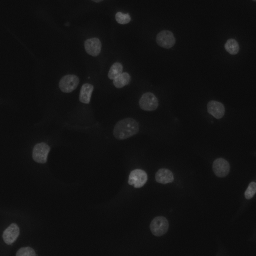

In [7]:
Image.open(IMAGE[0])

In [8]:
MASKS[0]

PosixPath('../data/ds_bowl_2018/stage1_train/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6/masks/89d3491cdcebca36a80f02b97fa71035da68fd321803c1e0a31cfa0b9d3d281a.png')

In [9]:
masks = [open_image(str(mask_path)) for mask_path in MASKS]

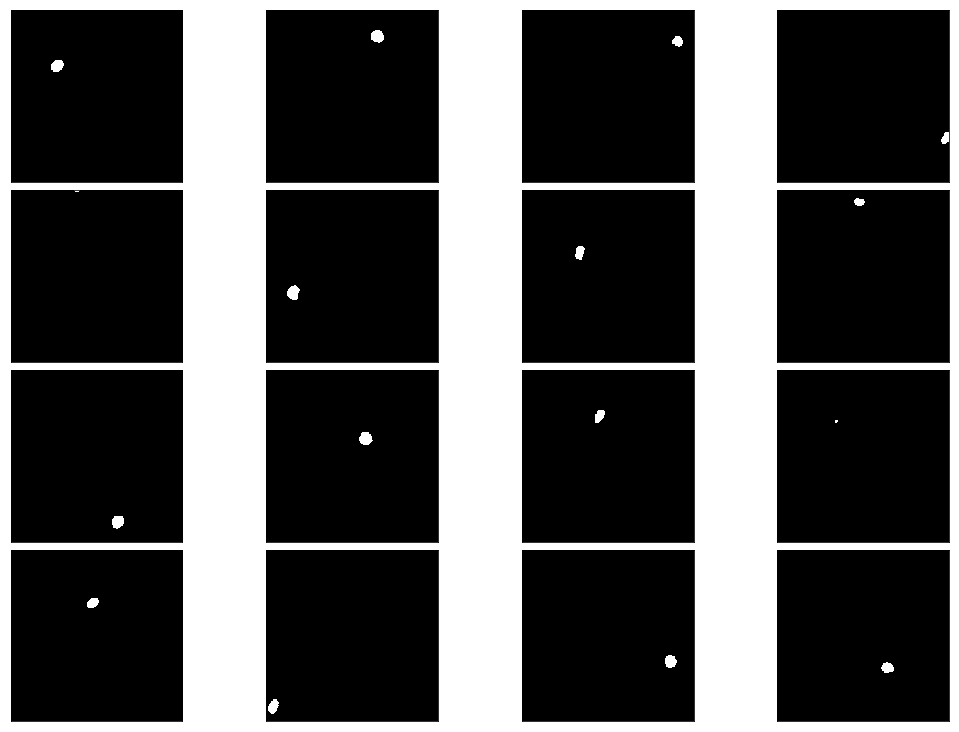

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat): show_img(masks[i], ax=ax)
plt.tight_layout(pad=0.1)

In [11]:
all_masks = np.sum(np.array(masks), 0)

In [12]:
gray = cv2.cvtColor(all_masks, cv2.COLOR_BGR2GRAY)

(t, binary) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

In [13]:
(binary)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
# contour for the mask i = 0
(_, contours, _) = cv2.findContours(binary.astype(np.uint8), 
                           cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [15]:
contoured_mask = cv2.drawContours(all_masks, contours, -1, (0, 0, 255), 2)

In [25]:
all_masks.shape

(256, 256, 3)

In [21]:
contoured_mask = cv2.drawContours(all_masks[0], contours[0], -1, (0, 0, 255), 2)

In [28]:
masks[0].shape

(256, 256, 3)

In [132]:
def get_contoured_mask2d(mask):
    """For a single mask file get contour"""
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    (t, binary) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    (_, contours, _) = cv2.findContours(binary.astype(np.uint8), 
                               cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contoured_mask = cv2.drawContours(mask, contours, -1, (0, 0, 255), 2)
    

    contoured_mask = get_contoured_mask(mask)

    contoured_mask2d = ((contoured_mask[:, :, 0]==1)*1) + ((contoured_mask[:, :, 2]==255)*2)
    return contoured_mask2d

In [148]:
# append all contoured mask files
def get_all_contoured_masks(masks):
    contoured_masks = []
    for mask in masks:
        contoured_masks.append(get_contoured_mask2d(mask))

    all_contoured_masks = np.sum(np.array(contoured_masks), 0)
    all_contoured_masks = np.clip(all_contoured_masks, 0,2)
    return all_contoured_masks

In [141]:
trn_dir = TRAIN_DIRS[0]

In [142]:
trn_dir

PosixPath('../data/ds_bowl_2018/stage1_train/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6')

In [146]:
# get all mask paths
mask_paths = list((trn_dir/'masks/').iterdir())

# read all masks
masks = [open_image(str(mask_path)) for mask_path in mask_paths]

# create multiclass mask
multiclass_mask = get_all_contoured_masks(masks)

# save mutliclass mask
plt.imsave(trn_dir/'multiclass_mask.png', multiclass_mask)

In [155]:
for trn_dir in TRAIN_DIRS:
    # get all mask paths
    mask_paths = list((trn_dir/'masks/').iterdir())

    # read all masks
    masks = [open_image(str(mask_path)) for mask_path in mask_paths]

    # create multiclass mask
    multiclass_mask = get_all_contoured_masks(masks)

    # save mutliclass mask
    plt.imsave(trn_dir/'multiclass_mask.png', multiclass_mask)


In [156]:
for trn_dir in TRAIN_DIRS:
    if open_image(str(trn_dir/'multiclass_mask.png')) is None:
        print(trn_dir.name)

In [137]:
np.unique(all_contoured_masks)

array([0, 1, 2, 3, 4, 6])

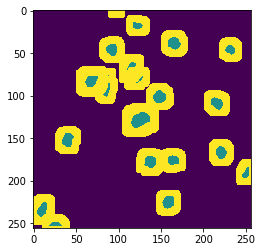

In [138]:
plt.imshow(np.clip(all_contoured_masks, 0,2))

In [73]:
np.unique(all_contoured_masks)

array([  0.,   1., 255., 256., 510.], dtype=float32)

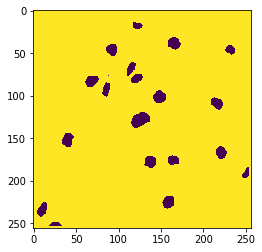

In [79]:
# multilcass setting classes 0, 1, 2
plt.imshow(clipped[:,:,0]==0)

### Pipeline: Multiclass Target Generation

In [24]:
MASKS[0]

PosixPath('../data/ds_bowl_2018/kaggle_fixed/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/masks/9047c2560c1fa473a9912f2019c8109329e2f8ee0403a252cc8d70e8872efb34.png')

In [25]:
# collect masks from mask_path of that image
masks = [open_image(str(mask_path)) for mask_path in MASKS]
# combine all masks
all_masks = np.sum(np.array(masks), 0)

In [26]:
def mclass_target_gen(mask_path):
    """takes mask paths and return mclass array"""
    # read mask
    mask = open_image(str(mask_path))
    # from BGR to GRAY
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # binarize for contouring
    (t, binary) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    # find contours with RETR_EXTERNAL method
    (_, contours, _) = cv2.findContours(binary.astype(np.uint8), 
                               cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # draw contours on original image
    contoured_mask = cv2.drawContours(mask, contours, -1, (0, 0, 255), 2)
    # generate 1 channel target array 0: background, 1: inside, 2: contour 
    out = np.clip(np.max(contoured_mask, 2), 0, 2)
    return out

In [27]:
# given training sample i
i = 1
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

In [28]:
all_masks = [mclass_target_gen(MASK) for MASK in MASKS]

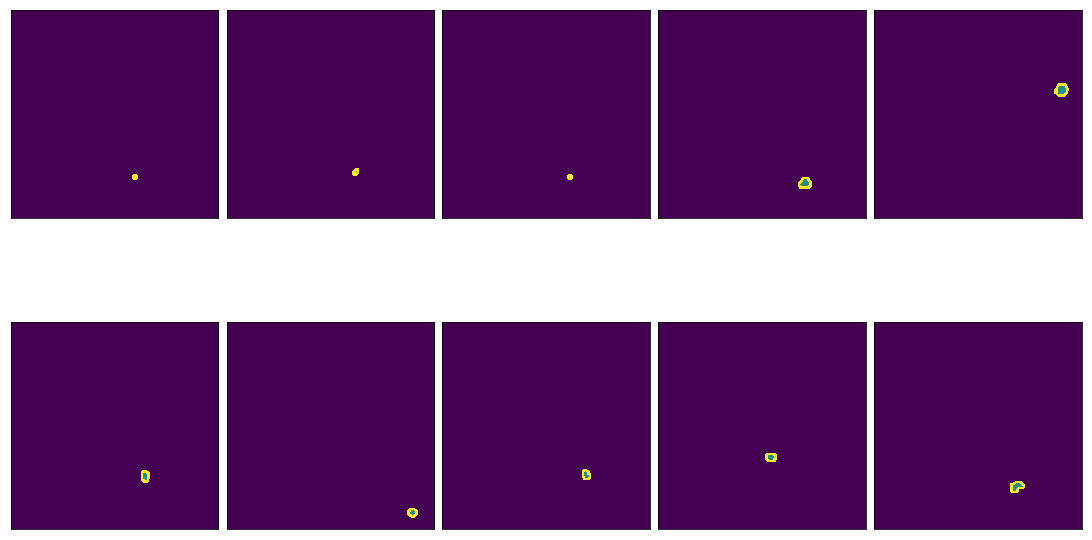

In [29]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for i,ax in enumerate(axes.flat): show_img(all_masks[i], ax=ax)
plt.tight_layout(pad=0.1)

### Create Multiclass Target Files

In [30]:
from concurrent.futures import ThreadPoolExecutor

In [31]:
# sample i
i = 0
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

In [32]:
MASKS[0].parent.parent/'mclass_target.png'

PosixPath('../data/ds_bowl_2018/kaggle_fixed/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/mclass_target.png')

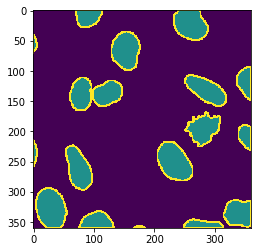

In [33]:
out = np.sum([mclass_target_gen(MASK) for MASK in MASKS], 0)
plt.imshow(out)
plt.imsave(MASKS[0].parent.parent/'mclass_target.png', out)

In [34]:
def create_mclass_target_file(i):
    IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
    MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())
    out = np.sum([mclass_target_gen(MASK) for MASK in MASKS], 0)
    out = np.clip(out, 0, 2)
    plt.imsave(str(MASKS[0].parent.parent/'mclass_target.png'), out)

In [35]:
idx_list = list(range(len(TRAIN_DIRS)))

In [36]:
# use all threads
with ThreadPoolExecutor(8) as e: e.map(create_mclass_target_file, idx_list)